# Hyperparameter Tuning

In this notebook we use boax to demonstrate a single step of a typical bayesion optimization process.

We will begin by defining the latent objective function we want to maximize and its bounds.

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax import prediction, optimization
from boax.core import distributions, samplers
from boax.prediction import kernels, likelihoods, means, models, objectives
from boax.optimization import acquisitions, optimizers

As our latent objective function we chose a sinusoid that we aim to maximize in the interval of [-5, 5].

In [2]:
data_key, sampler_key, optimizer_key = random.split(random.key(0), 3)

In [3]:
bounds = jnp.array([[0.0, 2.0]] * 2)

In [4]:
def objective(x):
    return (
        jnp.sin(5 * x[..., 0] / 2 - 2.5)
        * jnp.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

To create the observation training data we sample random points from a uniform distribution, evaluate the objective functions at those points, and finish by adding gaussian noise.

In [5]:
x_train = random.uniform(data_key, minval=bounds[:, 0], maxval=bounds[:, 1], shape=(1, 2))
y_train = objective(x_train)

In [6]:
grid = jnp.linspace(0, 2, 101)
x1, x2 = jnp.meshgrid(grid, grid, indexing="ij")
xs = jnp.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = objective(xs)

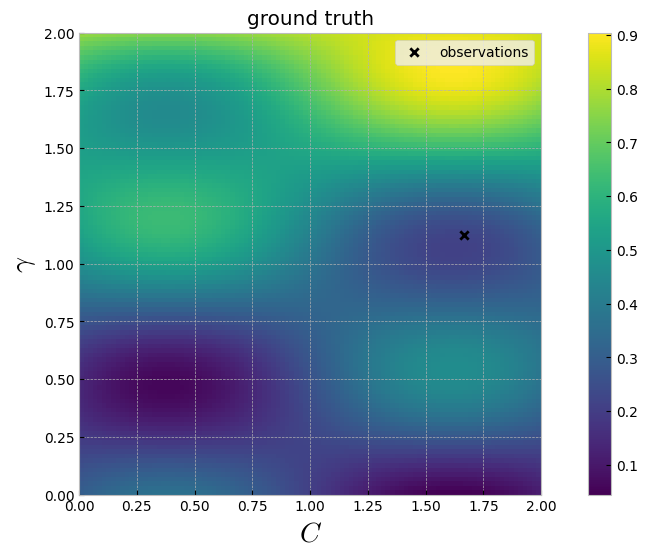

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

c = ax.imshow(ys.reshape(101, 101).T, origin="lower", extent=[0.0, 2.0, 0.0, 2.0])
ax.set_xlabel(r"$C$", fontsize=20)
ax.set_ylabel(r"$\gamma$", fontsize=20)
plt.colorbar(c, ax=ax)

ax.scatter(x_train[..., 0], x_train[..., 1], marker='x', c='k', label='observations')
ax.set_title("ground truth")
ax.legend()

plt.show()

## Fitting a Gaussian Process model to the data

With the observations in place, we can now focus on constructing a Gaussian Process model and fit it to the data. For this example we choose a simple setup of a constant zero mean function and a scaled RBF kernel. Note that we use the softplus function to constrain some of the models' hyperparameters to be strictly positive.

In [8]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros((2,)),
    'amplitude': jnp.zeros(()),
}

In [9]:
adam = optax.adam(0.01)

In [10]:
def fit(x_train, y_train):
    def prior(params):
        return models.outcome_transformed(
            models.gaussian_process(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude']
                ),
            ),
            likelihoods.gaussian(1e-4),
        )

    def posterior(params):
        return models.outcome_transformed(
            models.gaussian_process_regression(
                means.constant(params['mean']),
                kernels.scaled(
                    kernels.matern_five_halves(params['length_scale']),
                    params['amplitude']
                ),
            )(
                x_train,
                y_train,
            ),
            likelihoods.gaussian(1e-4),
        )

    def objective(params):
        return objectives.negative_log_likelihood(
            distributions.multivariate_normal.logpdf
        )

    def projection(params):
        return {
            'mean': params['mean'],
            'length_scale': nn.softplus(params['length_scale']),
            'amplitude': nn.softplus(params['amplitude']),
        }

    def step(state, i):
        loss_fn = prediction.construct(prior, objective, projection)
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return posterior(
        projection(next_params)
    )

## Constructing and optimizing an acquisition functions

In [11]:
x0 = jnp.reshape(
    samplers.halton_uniform(
        distributions.uniform.uniform(bounds[:, 0], bounds[:, 1])
    )(
        random.fold_in(sampler_key, 1),
        100 * 4,
    ),
    (100, 4, -1)
)

In [12]:
def optimize(key, acqf):
    bfgs = optimizers.bfgs(acqf, bounds, x0, 40)
    candidates = bfgs.init(key)
    next_candidates, values = bfgs.update(candidates)

    next_x = next_candidates[jnp.argmax(values)]
    next_y = objective(next_x)

    return next_x, next_y

In [13]:
def visualize(mean, x_train, next_x):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    c = axs[0].imshow(ys.reshape(101, 101).T, origin='lower', extent=[0.0, 2.0, 0.0, 2.0])
    axs[0].set_xlabel(r'$C$', fontsize=20)
    axs[0].set_ylabel(r'$\gamma$', fontsize=20)
    plt.colorbar(c, ax=axs[0])
    
    axs[0].scatter(x_train[..., 0], x_train[..., 1], marker='x', c='k', label='observations')
    axs[0].set_title('ground truth')
    axs[0].legend(loc='upper left')

    c = axs[1].imshow(mean.reshape(101, 101).T, origin='lower', extent=[0.0, 2.0, 0.0, 2.0])
    axs[1].set_xlabel(r'$C$', fontsize=20)
    plt.colorbar(c, ax=axs[1])
    
    axs[1].scatter(next_x[..., 0], next_x[..., 1], marker='x', c='k', label='next query')
    axs[1].set_title('mean')
    axs[1].legend(loc='upper left')

    plt.show()

In [14]:
base_samples = jnp.reshape(
    samplers.halton_normal()(
        random.fold_in(sampler_key, 0),
        128 * 4,
    ),
    (128, 4)
)

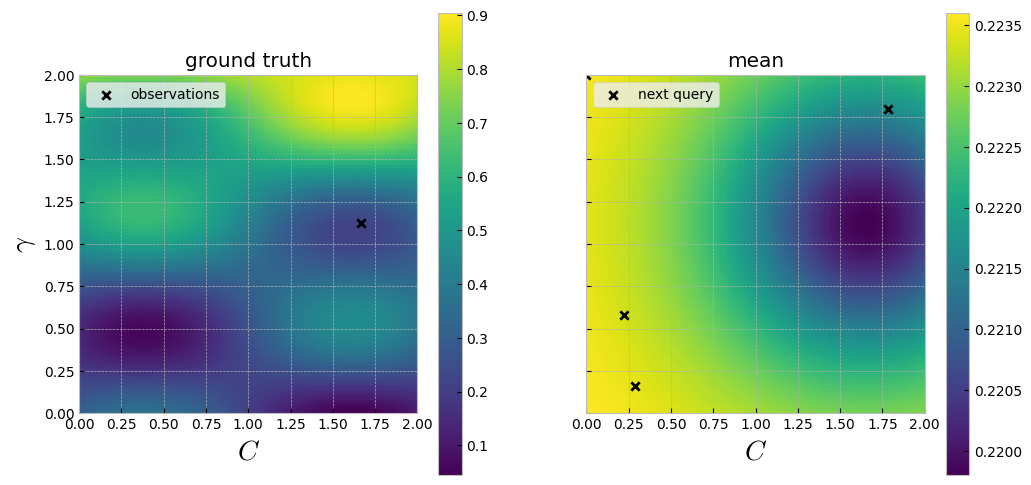

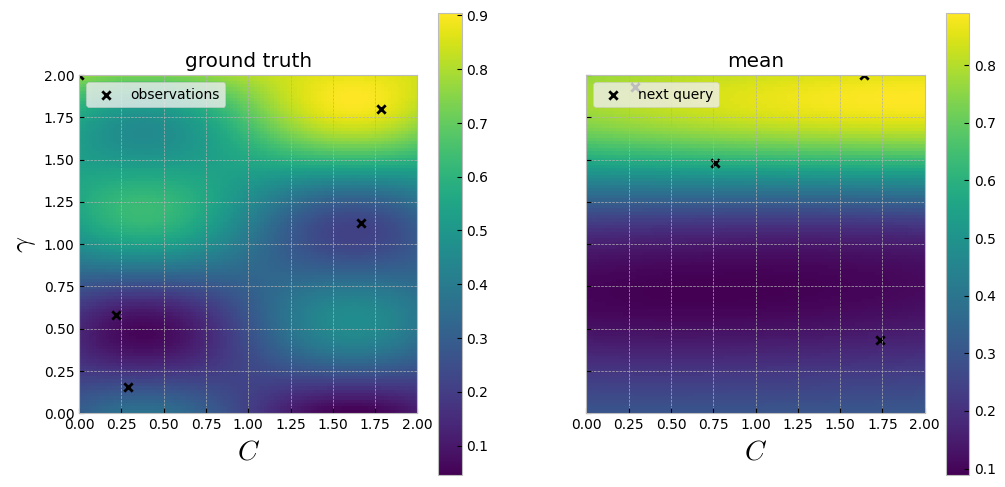

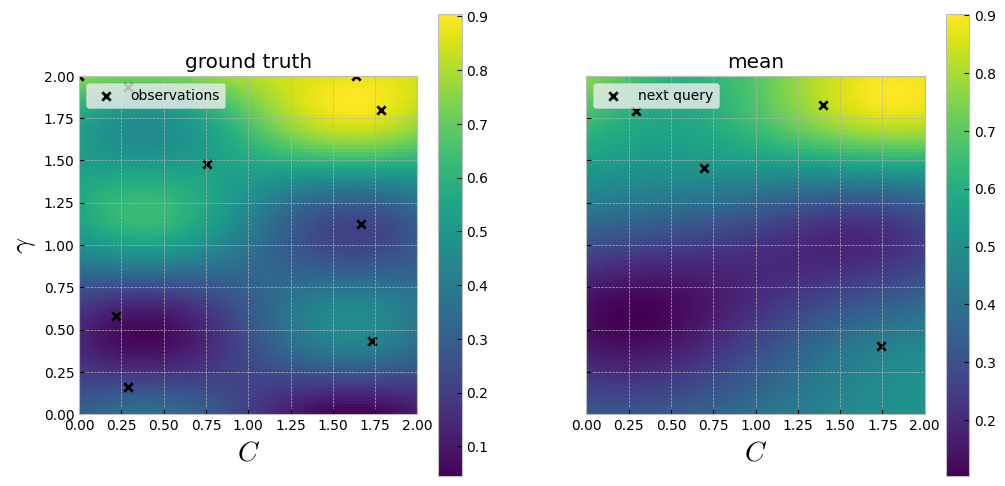

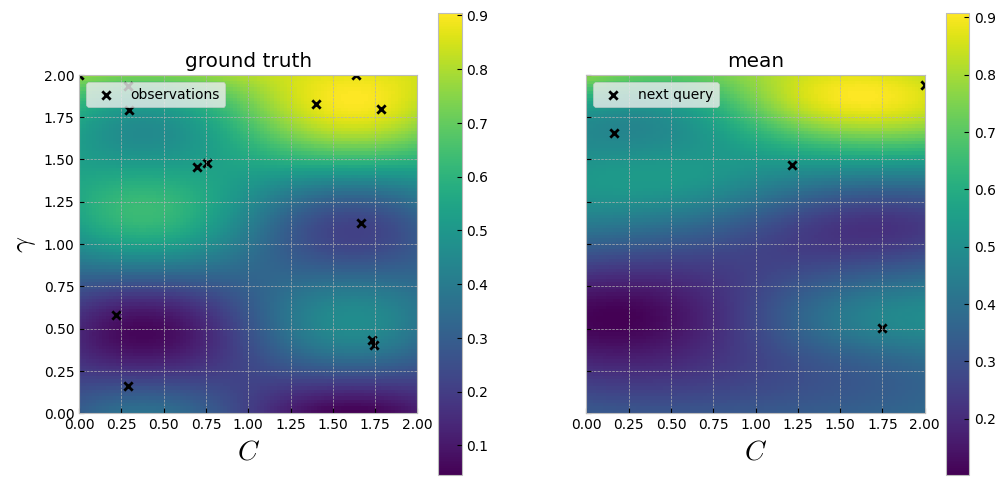

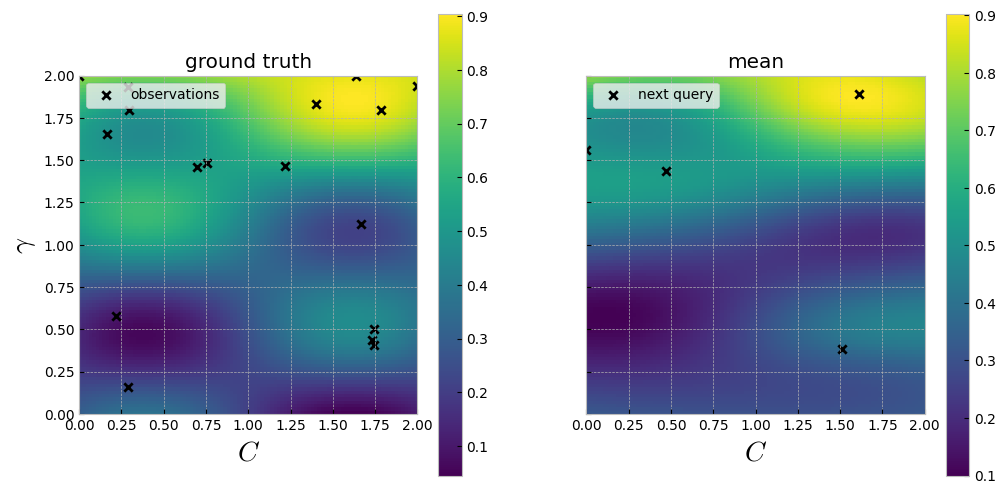

In [15]:
for i in range(5):    
    model = fit(x_train, y_train)

    acqf = optimization.construct(
        models.sampled(
            model,
            distributions.multivariate_normal.sample,
            base_samples
        ),
        acquisitions.q_probability_of_improvement(
            tau=1.0,
            best=1.1 * jnp.max(y_train),
        ),
    )

    next_x, next_y = optimize(
        random.fold_in(optimizer_key, i),
        acqf
    )

    preds = model(xs)
    
    visualize(preds.mean, x_train, next_x)

    x_train = jnp.vstack([x_train, next_x])
    y_train = jnp.hstack([y_train, next_y])